In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
clean ="/content/drive/MyDrive/50Input/50_Clean"
sharp = os.listdir(clean)

In [ ]:
import numpy as np
sharpN = np.array(sharp)
print(sharpN)

['Copy of 202.png' 'Copy of 201.png' 'Copy of 206.png' 'Copy of 203.png'
 'Copy of 209.png' 'Copy of 208.png' 'Copy of 207.png' 'Copy of 200.png'
 'Copy of 204.png' 'Copy of 205.png' 'Copy of 212.png' 'Copy of 216.png'
 'Copy of 217.png' 'Copy of 215.png' 'Copy of 210.png' 'Copy of 214.png'
 'Copy of 211.png' 'Copy of 219.png' 'Copy of 218.png' 'Copy of 213.png'
 'Copy of 222.png' 'Copy of 227.png' 'Copy of 225.png' 'Copy of 223.png'
 'Copy of 226.png' 'Copy of 221.png' 'Copy of 224.png' 'Copy of 228.png'
 'Copy of 229.png' 'Copy of 220.png' 'Copy of 231.png' 'Copy of 232.png'
 'Copy of 235.png' 'Copy of 239.png' 'Copy of 237.png' 'Copy of 230.png'
 'Copy of 234.png' 'Copy of 238.png' 'Copy of 233.png' 'Copy of 236.png'
 'Copy of 249.png' 'Copy of 242.png' 'Copy of 246.png' 'Copy of 243.png'
 'Copy of 245.png' 'Copy of 244.png' 'Copy of 241.png' 'Copy of 240.png'
 'Copy of 248.png' 'Copy of 247.png' 'Copy of 250.png']


In [ ]:
print(type(sharpN))

<class 'numpy.ndarray'>


In [ ]:
len(clean)

39

In [ ]:
len(sharp)

51

In [ ]:
input ="/content/drive/MyDrive/50Input/50_Blur"
gauss_blur = os.listdir(input)

In [ ]:
gauss_blurN = np.array(gauss_blur)
print(gauss_blurN)

['Copy of 202.png' 'Copy of 201.png' 'Copy of 206.png' 'Copy of 203.png'
 'Copy of 209.png' 'Copy of 208.png' 'Copy of 207.png' 'Copy of 200.png'
 'Copy of 204.png' 'Copy of 205.png' 'Copy of 212.png' 'Copy of 216.png'
 'Copy of 217.png' 'Copy of 215.png' 'Copy of 210.png' 'Copy of 214.png'
 'Copy of 211.png' 'Copy of 219.png' 'Copy of 218.png' 'Copy of 213.png'
 'Copy of 222.png' 'Copy of 227.png' 'Copy of 225.png' 'Copy of 223.png'
 'Copy of 226.png' 'Copy of 221.png' 'Copy of 224.png' 'Copy of 228.png'
 'Copy of 229.png' 'Copy of 220.png' 'Copy of 231.png' 'Copy of 232.png'
 'Copy of 235.png' 'Copy of 239.png' 'Copy of 237.png' 'Copy of 230.png'
 'Copy of 234.png' 'Copy of 238.png' 'Copy of 233.png' 'Copy of 236.png'
 'Copy of 249.png' 'Copy of 242.png' 'Copy of 246.png' 'Copy of 243.png'
 'Copy of 245.png' 'Copy of 244.png' 'Copy of 241.png' 'Copy of 240.png'
 'Copy of 248.png' 'Copy of 247.png' 'Copy of 250.png']


In [ ]:
len(input)

38

In [ ]:
len(gauss_blur)

51

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import math
import h5py
import argparse
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split

In [ ]:
# constructing the argument parser
parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument('-e', '--epochs', type=int, default=100, 
            help='number of epochs to train the model for')
args = vars(parser.parse_args())
def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 128, 128)
    save_image(img, name)

In [ ]:
# helper functions
image_dir = '/content/drive/MyDrive/50Output/saved_images'
os.makedirs(image_dir, exist_ok=True)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

batch_size = 32

cpu


In [ ]:
gauss_blur = os.listdir('/content/drive/MyDrive/50Input/50_Blur')
gauss_blur.sort()
sharp = os.listdir('/content/drive/MyDrive/50Input/50_Clean')
sharp.sort()

x_blur = []
for i in range(len(gauss_blur)):
    x_blur.append(gauss_blur[i])

y_sharp = []
for i in range(len(sharp)):
    y_sharp.append(sharp[i])

In [ ]:
(x_train, x_val, y_train, y_val) = train_test_split(x_blur, y_sharp, test_size=0.10)
print(f"Train data instances: {len(x_train)}")
print(f"Validation data instances: {len(x_val)}")

Train data instances: 45
Validation data instances: 6


In [ ]:
# define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [ ]:
class DeblurDataset(Dataset):
    def __init__(self, blur_paths, sharp_paths=None, transforms=None):
        self.X = blur_paths
        self.y = sharp_paths
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        blur_image = cv2.imread(f"/content/drive/MyDrive/50Input/50_Blur/{self.X[i]}")
        
        if self.transforms:
            blur_image = self.transforms(blur_image)
            
        if self.y is not None:
            sharp_image = cv2.imread(f"/content/drive/MyDrive/50Input/50_Clean/{self.y[i]}")
            sharp_image = self.transforms(sharp_image)
            return (blur_image, sharp_image)
        else:
            return blur_image

In [ ]:
train_data = DeblurDataset(x_train, y_train, transform)
val_data = DeblurDataset(x_val, y_val, transform)
batch_size = 1
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [ ]:
class DeblurCNN(nn.Module):
    def __init__(self):
        super(DeblurCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
model = DeblurCNN().to(device)
print(model)

cpu
DeblurCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [ ]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
        optimizer,
        mode='min',
        patience=5,
        factor=0.5,
        verbose=True
    )

In [ ]:
def psnr(label, outputs, max_val=1.):
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

In [ ]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        blur_image = data[0]
        sharp_image = data[1]
        blur_image = blur_image.to(device)
        sharp_image = sharp_image.to(device)
        optimizer.zero_grad()
        outputs = model(blur_image)
        loss = criterion(outputs, sharp_image)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        running_loss += loss.item()
        batch_psnr =  psnr(sharp_image, outputs)
        running_psnr += batch_psnr
    train_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(train_data)/dataloader.batch_size)
    print(f"Train Loss: {train_loss:.5f} PSNR: {final_psnr:.5f} PSNR(gT&blur): {psnr(sharp_image, blur_image):.5f}")
    return train_loss, final_psnr

In [ ]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            blur_image = data[0]
            sharp_image = data[1]
            blur_image = blur_image.to(device)
            sharp_image = sharp_image.to(device)
            outputs = model(blur_image)
            loss = criterion(outputs, sharp_image)
            running_loss += loss.item()
            batch_psnr = psnr(sharp_image, outputs)
            running_psnr += batch_psnr
            if epoch == 0:
                save_decoded_image(sharp_image.cpu().data, name=f"/content/drive/MyDrive/50Output/saved_images/sharp{epoch}.jpg")
                save_decoded_image(blur_image.cpu().data, name=f"/content/drive/MyDrive/50Output/saved_images/blur{epoch}.jpg")
            if epoch == 99:
                save_decoded_image(outputs.cpu().data, name=f"/content/drive/MyDrive/50Output/saved_images/val_deblurred{epoch}.jpg")
        val_loss = running_loss/len(dataloader.dataset)
        final_psnr = running_psnr/int(len(val_data)/dataloader.batch_size)
        print(f"Val Loss: {val_loss:.5f} PSNR: {final_psnr:.5f} PSNR(gT&blur): {psnr(sharp_image, blur_image):.5f}")
        
        return val_loss, final_psnr

In [ ]:
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(args['epochs']):
    print(f"Epoch {epoch+1} of {args['epochs']}")
    train_epoch_loss, train_epoch_psnr = fit(model, trainloader)
    val_epoch_loss, val_epoch_psnr = validate(model, valloader, epoch)
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
    scheduler.step(val_epoch_loss)
end = time.time()
print(f"Took {((end-start)/60):.3f} minutes to train")

Epoch 1 of 100


100%|██████████| 45/45 [00:05<00:00,  8.24it/s]


Train Loss: 0.00065 PSNR: 32.05773 PSNR(gT&blur): 30.51009


100%|██████████| 6/6 [00:00<00:00, 10.13it/s]


Val Loss: 0.00070 PSNR: 31.59377 PSNR(gT&blur): 33.05639
Epoch 2 of 100


100%|██████████| 45/45 [00:05<00:00,  8.32it/s]


Train Loss: 0.00062 PSNR: 32.25847 PSNR(gT&blur): 30.33535


100%|██████████| 6/6 [00:00<00:00, 11.50it/s]


Val Loss: 0.00071 PSNR: 31.54732 PSNR(gT&blur): 33.05639
Epoch 3 of 100


100%|██████████| 45/45 [00:05<00:00,  8.43it/s]


Train Loss: 0.00060 PSNR: 32.40979 PSNR(gT&blur): 28.75624


100%|██████████| 6/6 [00:00<00:00, 11.06it/s]


Val Loss: 0.00068 PSNR: 31.71695 PSNR(gT&blur): 33.05639
Epoch 4 of 100


100%|██████████| 45/45 [00:05<00:00,  8.12it/s]


Train Loss: 0.00060 PSNR: 32.43316 PSNR(gT&blur): 30.57462


100%|██████████| 6/6 [00:00<00:00, 11.04it/s]


Val Loss: 0.00065 PSNR: 31.90068 PSNR(gT&blur): 33.05639
Epoch 5 of 100


100%|██████████| 45/45 [00:05<00:00,  8.39it/s]


Train Loss: 0.00060 PSNR: 32.42156 PSNR(gT&blur): 30.57756


100%|██████████| 6/6 [00:00<00:00, 11.37it/s]


Val Loss: 0.00069 PSNR: 31.68579 PSNR(gT&blur): 33.05639
Epoch 6 of 100


100%|██████████| 45/45 [00:05<00:00,  8.40it/s]


Train Loss: 0.00063 PSNR: 32.18055 PSNR(gT&blur): 29.95999


100%|██████████| 6/6 [00:00<00:00, 11.44it/s]


Val Loss: 0.00070 PSNR: 31.61443 PSNR(gT&blur): 33.05639
Epoch 7 of 100


100%|██████████| 45/45 [00:05<00:00,  8.23it/s]


Train Loss: 0.00064 PSNR: 32.14806 PSNR(gT&blur): 30.61089


100%|██████████| 6/6 [00:00<00:00, 11.24it/s]


Val Loss: 0.00071 PSNR: 31.52364 PSNR(gT&blur): 33.05639
Epoch 8 of 100


100%|██████████| 45/45 [00:05<00:00,  8.06it/s]


Train Loss: 0.00059 PSNR: 32.48550 PSNR(gT&blur): 30.43778


100%|██████████| 6/6 [00:00<00:00, 10.80it/s]


Val Loss: 0.00065 PSNR: 31.91019 PSNR(gT&blur): 33.05639
Epoch 9 of 100


100%|██████████| 45/45 [00:05<00:00,  8.02it/s]


Train Loss: 0.00067 PSNR: 31.99407 PSNR(gT&blur): 30.57987


100%|██████████| 6/6 [00:00<00:00, 11.05it/s]


Val Loss: 0.00069 PSNR: 31.64171 PSNR(gT&blur): 33.05639
Epoch 10 of 100


100%|██████████| 45/45 [00:05<00:00,  7.96it/s]


Train Loss: 0.00058 PSNR: 32.58456 PSNR(gT&blur): 30.22757


100%|██████████| 6/6 [00:00<00:00, 11.01it/s]


Val Loss: 0.00064 PSNR: 31.97678 PSNR(gT&blur): 33.05639
Epoch 11 of 100


100%|██████████| 45/45 [00:05<00:00,  8.03it/s]


Train Loss: 0.00055 PSNR: 32.77450 PSNR(gT&blur): 33.45093


100%|██████████| 6/6 [00:00<00:00, 11.01it/s]


Val Loss: 0.00069 PSNR: 31.65670 PSNR(gT&blur): 33.05639
Epoch 12 of 100


100%|██████████| 45/45 [00:05<00:00,  8.07it/s]


Train Loss: 0.00059 PSNR: 32.48752 PSNR(gT&blur): 30.64627


100%|██████████| 6/6 [00:00<00:00, 10.90it/s]


Val Loss: 0.00065 PSNR: 31.91332 PSNR(gT&blur): 33.05639
Epoch 13 of 100


100%|██████████| 45/45 [00:05<00:00,  8.00it/s]


Train Loss: 0.00059 PSNR: 32.47105 PSNR(gT&blur): 31.62925


100%|██████████| 6/6 [00:00<00:00, 10.56it/s]


Val Loss: 0.00063 PSNR: 32.04248 PSNR(gT&blur): 33.05639
Epoch 14 of 100


100%|██████████| 45/45 [00:05<00:00,  7.93it/s]


Train Loss: 0.00057 PSNR: 32.64020 PSNR(gT&blur): 33.36995


100%|██████████| 6/6 [00:00<00:00, 10.58it/s]


Val Loss: 0.00074 PSNR: 31.31268 PSNR(gT&blur): 33.05639
Epoch 15 of 100


100%|██████████| 45/45 [00:05<00:00,  8.06it/s]


Train Loss: 0.00078 PSNR: 31.42097 PSNR(gT&blur): 29.20485


100%|██████████| 6/6 [00:00<00:00, 11.44it/s]


Val Loss: 0.00143 PSNR: 28.46115 PSNR(gT&blur): 33.05639
Epoch 16 of 100


100%|██████████| 45/45 [00:05<00:00,  8.35it/s]


Train Loss: 0.00118 PSNR: 29.56922 PSNR(gT&blur): 30.22757


100%|██████████| 6/6 [00:00<00:00, 11.01it/s]


Val Loss: 0.00112 PSNR: 29.50496 PSNR(gT&blur): 33.05639
Epoch 17 of 100


100%|██████████| 45/45 [00:05<00:00,  8.39it/s]


Train Loss: 0.00072 PSNR: 31.70933 PSNR(gT&blur): 30.51009


100%|██████████| 6/6 [00:00<00:00, 11.43it/s]


Val Loss: 0.00066 PSNR: 31.83729 PSNR(gT&blur): 33.05639
Epoch 18 of 100


100%|██████████| 45/45 [00:05<00:00,  8.41it/s]


Train Loss: 0.00056 PSNR: 32.67030 PSNR(gT&blur): 30.05242


100%|██████████| 6/6 [00:00<00:00, 11.60it/s]


Val Loss: 0.00061 PSNR: 32.15137 PSNR(gT&blur): 33.05639
Epoch 19 of 100


100%|██████████| 45/45 [00:05<00:00,  8.20it/s]


Train Loss: 0.00107 PSNR: 30.72930 PSNR(gT&blur): 30.57462


100%|██████████| 6/6 [00:00<00:00, 11.42it/s]


Val Loss: 0.00084 PSNR: 30.80461 PSNR(gT&blur): 33.05639
Epoch 20 of 100


100%|██████████| 45/45 [00:05<00:00,  8.10it/s]


Train Loss: 0.00086 PSNR: 30.81930 PSNR(gT&blur): 32.68950


100%|██████████| 6/6 [00:00<00:00, 10.93it/s]


Val Loss: 0.00068 PSNR: 31.71548 PSNR(gT&blur): 33.05639
Epoch 21 of 100


100%|██████████| 45/45 [00:05<00:00,  8.01it/s]


Train Loss: 0.00064 PSNR: 32.12958 PSNR(gT&blur): 28.81718


100%|██████████| 6/6 [00:00<00:00, 11.30it/s]


Val Loss: 0.00061 PSNR: 32.16787 PSNR(gT&blur): 33.05639
Epoch 22 of 100


100%|██████████| 45/45 [00:05<00:00,  7.97it/s]


Train Loss: 0.00051 PSNR: 33.12342 PSNR(gT&blur): 32.10951


100%|██████████| 6/6 [00:00<00:00, 10.86it/s]


Val Loss: 0.00058 PSNR: 32.43907 PSNR(gT&blur): 33.05639
Epoch 23 of 100


100%|██████████| 45/45 [00:05<00:00,  8.02it/s]


Train Loss: 0.00050 PSNR: 33.25805 PSNR(gT&blur): 30.23184


100%|██████████| 6/6 [00:00<00:00, 11.07it/s]


Val Loss: 0.00056 PSNR: 32.59553 PSNR(gT&blur): 33.05639
Epoch 24 of 100


100%|██████████| 45/45 [00:05<00:00,  8.24it/s]


Train Loss: 0.00048 PSNR: 33.35298 PSNR(gT&blur): 30.34356


100%|██████████| 6/6 [00:00<00:00, 11.31it/s]


Val Loss: 0.00056 PSNR: 32.53033 PSNR(gT&blur): 33.05639
Epoch 25 of 100


100%|██████████| 45/45 [00:05<00:00,  8.28it/s]


Train Loss: 0.00049 PSNR: 33.32693 PSNR(gT&blur): 30.34356


100%|██████████| 6/6 [00:00<00:00, 10.99it/s]


Val Loss: 0.00056 PSNR: 32.54926 PSNR(gT&blur): 33.05639
Epoch 26 of 100


100%|██████████| 45/45 [00:05<00:00,  8.27it/s]


Train Loss: 0.00050 PSNR: 33.21736 PSNR(gT&blur): 30.54099


100%|██████████| 6/6 [00:00<00:00, 11.57it/s]


Val Loss: 0.00058 PSNR: 32.38281 PSNR(gT&blur): 33.05639
Epoch 27 of 100


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Train Loss: 0.00051 PSNR: 33.10988 PSNR(gT&blur): 34.15825


100%|██████████| 6/6 [00:00<00:00, 11.24it/s]


Val Loss: 0.00055 PSNR: 32.63675 PSNR(gT&blur): 33.05639
Epoch 28 of 100


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Train Loss: 0.00052 PSNR: 33.03402 PSNR(gT&blur): 31.03738


100%|██████████| 6/6 [00:00<00:00, 11.45it/s]


Val Loss: 0.00061 PSNR: 32.21252 PSNR(gT&blur): 33.05639
Epoch 29 of 100


100%|██████████| 45/45 [00:05<00:00,  8.42it/s]


Train Loss: 0.00050 PSNR: 33.21833 PSNR(gT&blur): 33.40506


100%|██████████| 6/6 [00:00<00:00, 11.35it/s]


Val Loss: 0.00054 PSNR: 32.67306 PSNR(gT&blur): 33.05639
Epoch 30 of 100


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Train Loss: 0.00048 PSNR: 33.38412 PSNR(gT&blur): 30.57987


100%|██████████| 6/6 [00:00<00:00, 11.20it/s]


Val Loss: 0.00055 PSNR: 32.60771 PSNR(gT&blur): 33.05639
Epoch 31 of 100


100%|██████████| 45/45 [00:05<00:00,  8.16it/s]


Train Loss: 0.00050 PSNR: 33.15547 PSNR(gT&blur): 29.20485


100%|██████████| 6/6 [00:00<00:00, 10.49it/s]


Val Loss: 0.00054 PSNR: 32.70463 PSNR(gT&blur): 33.05639
Epoch 32 of 100


100%|██████████| 45/45 [00:05<00:00,  8.15it/s]


Train Loss: 0.00046 PSNR: 33.62062 PSNR(gT&blur): 30.51009


100%|██████████| 6/6 [00:00<00:00, 11.13it/s]


Val Loss: 0.00052 PSNR: 32.89207 PSNR(gT&blur): 33.05639
Epoch 33 of 100


100%|██████████| 45/45 [00:05<00:00,  8.21it/s]


Train Loss: 0.00045 PSNR: 33.65934 PSNR(gT&blur): 33.35416


100%|██████████| 6/6 [00:00<00:00, 10.98it/s]


Val Loss: 0.00056 PSNR: 32.51093 PSNR(gT&blur): 33.05639
Epoch 34 of 100


100%|██████████| 45/45 [00:05<00:00,  8.21it/s]


Train Loss: 0.00045 PSNR: 33.62517 PSNR(gT&blur): 29.32458


100%|██████████| 6/6 [00:00<00:00, 11.16it/s]


Val Loss: 0.00053 PSNR: 32.78346 PSNR(gT&blur): 33.05639
Epoch 35 of 100


100%|██████████| 45/45 [00:05<00:00,  7.99it/s]


Train Loss: 0.00044 PSNR: 33.79115 PSNR(gT&blur): 30.51009


100%|██████████| 6/6 [00:00<00:00, 10.87it/s]


Val Loss: 0.00050 PSNR: 33.08267 PSNR(gT&blur): 33.05639
Epoch 36 of 100


100%|██████████| 45/45 [00:05<00:00,  8.14it/s]


Train Loss: 0.00046 PSNR: 33.54335 PSNR(gT&blur): 28.81718


100%|██████████| 6/6 [00:00<00:00, 11.08it/s]


Val Loss: 0.00050 PSNR: 33.02126 PSNR(gT&blur): 33.05639
Epoch 37 of 100


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Train Loss: 0.00056 PSNR: 32.77592 PSNR(gT&blur): 30.59449


100%|██████████| 6/6 [00:00<00:00, 10.90it/s]


Val Loss: 0.00055 PSNR: 32.65393 PSNR(gT&blur): 33.05639
Epoch 38 of 100


100%|██████████| 45/45 [00:05<00:00,  8.29it/s]


Train Loss: 0.00055 PSNR: 32.79974 PSNR(gT&blur): 31.36493


100%|██████████| 6/6 [00:00<00:00, 11.16it/s]


Val Loss: 0.00050 PSNR: 33.07330 PSNR(gT&blur): 33.05639
Epoch 39 of 100


100%|██████████| 45/45 [00:05<00:00,  8.28it/s]


Train Loss: 0.00049 PSNR: 33.31322 PSNR(gT&blur): 33.83365


100%|██████████| 6/6 [00:00<00:00, 11.21it/s]


Val Loss: 0.00081 PSNR: 30.91751 PSNR(gT&blur): 33.05639
Epoch 40 of 100


100%|██████████| 45/45 [00:05<00:00,  8.30it/s]


Train Loss: 0.00046 PSNR: 33.51549 PSNR(gT&blur): 30.59449


100%|██████████| 6/6 [00:00<00:00, 11.39it/s]


Val Loss: 0.00049 PSNR: 33.13713 PSNR(gT&blur): 33.05639
Epoch 41 of 100


100%|██████████| 45/45 [00:05<00:00,  8.42it/s]


Train Loss: 0.00048 PSNR: 33.41184 PSNR(gT&blur): 30.05242


100%|██████████| 6/6 [00:00<00:00, 11.85it/s]


Val Loss: 0.00052 PSNR: 32.85915 PSNR(gT&blur): 33.05639
Epoch 42 of 100


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Train Loss: 0.00045 PSNR: 33.64651 PSNR(gT&blur): 30.23184


100%|██████████| 6/6 [00:00<00:00, 11.28it/s]


Val Loss: 0.00049 PSNR: 33.09329 PSNR(gT&blur): 33.05639
Epoch 43 of 100


100%|██████████| 45/45 [00:05<00:00,  8.17it/s]


Train Loss: 0.00048 PSNR: 33.38632 PSNR(gT&blur): 30.78565


100%|██████████| 6/6 [00:00<00:00, 11.44it/s]


Val Loss: 0.00053 PSNR: 32.77188 PSNR(gT&blur): 33.05639
Epoch 44 of 100


100%|██████████| 45/45 [00:05<00:00,  8.36it/s]


Train Loss: 0.00043 PSNR: 33.82110 PSNR(gT&blur): 29.88393


100%|██████████| 6/6 [00:00<00:00, 10.93it/s]


Val Loss: 0.00050 PSNR: 32.99596 PSNR(gT&blur): 33.05639
Epoch 45 of 100


100%|██████████| 45/45 [00:05<00:00,  8.18it/s]


Train Loss: 0.00042 PSNR: 34.00614 PSNR(gT&blur): 30.88232


100%|██████████| 6/6 [00:00<00:00, 11.48it/s]


Val Loss: 0.00047 PSNR: 33.35187 PSNR(gT&blur): 33.05639
Epoch 46 of 100


100%|██████████| 45/45 [00:05<00:00,  8.25it/s]


Train Loss: 0.00041 PSNR: 34.06078 PSNR(gT&blur): 30.58374


100%|██████████| 6/6 [00:00<00:00, 10.91it/s]


Val Loss: 0.00048 PSNR: 33.19288 PSNR(gT&blur): 33.05639
Epoch 47 of 100


100%|██████████| 45/45 [00:05<00:00,  7.97it/s]


Train Loss: 0.00040 PSNR: 34.15676 PSNR(gT&blur): 30.33535


100%|██████████| 6/6 [00:00<00:00, 11.11it/s]


Val Loss: 0.00045 PSNR: 33.55168 PSNR(gT&blur): 33.05639
Epoch 48 of 100


100%|██████████| 45/45 [00:05<00:00,  8.09it/s]


Train Loss: 0.00069 PSNR: 31.91312 PSNR(gT&blur): 30.57462


100%|██████████| 6/6 [00:00<00:00, 11.18it/s]


Val Loss: 0.00054 PSNR: 32.70124 PSNR(gT&blur): 33.05639
Epoch 49 of 100


100%|██████████| 45/45 [00:05<00:00,  8.23it/s]


Train Loss: 0.00051 PSNR: 33.15423 PSNR(gT&blur): 30.23184


100%|██████████| 6/6 [00:00<00:00, 11.40it/s]


Val Loss: 0.00052 PSNR: 32.84764 PSNR(gT&blur): 33.05639
Epoch 50 of 100


100%|██████████| 45/45 [00:05<00:00,  8.24it/s]


Train Loss: 0.00065 PSNR: 32.18899 PSNR(gT&blur): 30.29004


100%|██████████| 6/6 [00:00<00:00, 11.40it/s]


Val Loss: 0.00089 PSNR: 30.71232 PSNR(gT&blur): 33.05639
Epoch 51 of 100


100%|██████████| 45/45 [00:05<00:00,  8.39it/s]


Train Loss: 0.00053 PSNR: 32.89804 PSNR(gT&blur): 32.10951


100%|██████████| 6/6 [00:00<00:00, 11.12it/s]


Val Loss: 0.00049 PSNR: 33.11839 PSNR(gT&blur): 33.05639
Epoch 52 of 100


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


Train Loss: 0.00043 PSNR: 33.87875 PSNR(gT&blur): 34.15825


100%|██████████| 6/6 [00:00<00:00, 11.15it/s]


Val Loss: 0.00044 PSNR: 33.58306 PSNR(gT&blur): 33.05639
Epoch 53 of 100


100%|██████████| 45/45 [00:05<00:00,  8.31it/s]


Train Loss: 0.00047 PSNR: 33.46329 PSNR(gT&blur): 30.23184


100%|██████████| 6/6 [00:00<00:00, 11.30it/s]


Val Loss: 0.00045 PSNR: 33.52153 PSNR(gT&blur): 33.05639
Epoch 54 of 100


100%|██████████| 45/45 [00:05<00:00,  8.54it/s]


Train Loss: 0.00043 PSNR: 33.78755 PSNR(gT&blur): 30.13598


100%|██████████| 6/6 [00:00<00:00, 11.48it/s]


Val Loss: 0.00055 PSNR: 32.61913 PSNR(gT&blur): 33.05639
Epoch 55 of 100


100%|██████████| 45/45 [00:05<00:00,  8.40it/s]


Train Loss: 0.00043 PSNR: 33.93132 PSNR(gT&blur): 31.62925


100%|██████████| 6/6 [00:00<00:00, 11.79it/s]


Val Loss: 0.00051 PSNR: 32.96481 PSNR(gT&blur): 33.05639
Epoch 56 of 100


100%|██████████| 45/45 [00:05<00:00,  8.43it/s]


Train Loss: 0.00038 PSNR: 34.38046 PSNR(gT&blur): 29.24927


100%|██████████| 6/6 [00:00<00:00, 11.41it/s]


Val Loss: 0.00042 PSNR: 33.77248 PSNR(gT&blur): 33.05639
Epoch 57 of 100


100%|██████████| 45/45 [00:05<00:00,  8.48it/s]


Train Loss: 0.00038 PSNR: 34.41432 PSNR(gT&blur): 32.39556


100%|██████████| 6/6 [00:00<00:00, 11.39it/s]


Val Loss: 0.00055 PSNR: 32.63264 PSNR(gT&blur): 33.05639
Epoch 58 of 100


100%|██████████| 45/45 [00:05<00:00,  8.50it/s]


Train Loss: 0.00039 PSNR: 34.28107 PSNR(gT&blur): 29.88393


100%|██████████| 6/6 [00:00<00:00, 10.83it/s]


Val Loss: 0.00055 PSNR: 32.60761 PSNR(gT&blur): 33.05639
Epoch 59 of 100


100%|██████████| 45/45 [00:05<00:00,  8.35it/s]


Train Loss: 0.00050 PSNR: 33.15118 PSNR(gT&blur): 30.33535


100%|██████████| 6/6 [00:00<00:00, 11.39it/s]


Val Loss: 0.00055 PSNR: 32.65125 PSNR(gT&blur): 33.05639
Epoch 60 of 100


100%|██████████| 45/45 [00:05<00:00,  8.21it/s]


Train Loss: 0.00042 PSNR: 33.99186 PSNR(gT&blur): 29.24927


100%|██████████| 6/6 [00:00<00:00, 11.24it/s]


Val Loss: 0.00052 PSNR: 32.88813 PSNR(gT&blur): 33.05639
Epoch 61 of 100


100%|██████████| 45/45 [00:05<00:00,  8.28it/s]


Train Loss: 0.00040 PSNR: 34.17738 PSNR(gT&blur): 30.64627


100%|██████████| 6/6 [00:00<00:00, 11.21it/s]


Val Loss: 0.00046 PSNR: 33.38247 PSNR(gT&blur): 33.05639
Epoch 62 of 100


100%|██████████| 45/45 [00:05<00:00,  8.13it/s]


Train Loss: 0.00042 PSNR: 33.93452 PSNR(gT&blur): 30.59449


100%|██████████| 6/6 [00:00<00:00, 10.51it/s]


Val Loss: 0.00043 PSNR: 33.71838 PSNR(gT&blur): 33.05639
Epoch   136: reducing learning rate of group 0 to 5.0000e-04.
Epoch 63 of 100


100%|██████████| 45/45 [00:05<00:00,  8.14it/s]


Train Loss: 0.00035 PSNR: 34.75484 PSNR(gT&blur): 29.88633


100%|██████████| 6/6 [00:00<00:00, 11.00it/s]


Val Loss: 0.00042 PSNR: 33.77068 PSNR(gT&blur): 33.05639
Epoch 64 of 100


100%|██████████| 45/45 [00:05<00:00,  8.14it/s]


Train Loss: 0.00034 PSNR: 34.90662 PSNR(gT&blur): 29.95999


100%|██████████| 6/6 [00:00<00:00, 10.58it/s]


Val Loss: 0.00039 PSNR: 34.07433 PSNR(gT&blur): 33.05639
Epoch 65 of 100


100%|██████████| 45/45 [00:05<00:00,  8.07it/s]


Train Loss: 0.00034 PSNR: 34.97140 PSNR(gT&blur): 30.59449


100%|██████████| 6/6 [00:00<00:00, 11.00it/s]


Val Loss: 0.00040 PSNR: 34.05707 PSNR(gT&blur): 33.05639
Epoch 66 of 100


100%|██████████| 45/45 [00:05<00:00,  8.17it/s]


Train Loss: 0.00033 PSNR: 35.00314 PSNR(gT&blur): 30.88232


100%|██████████| 6/6 [00:00<00:00, 11.28it/s]


Val Loss: 0.00040 PSNR: 34.02183 PSNR(gT&blur): 33.05639
Epoch 67 of 100


100%|██████████| 45/45 [00:05<00:00,  8.05it/s]


Train Loss: 0.00033 PSNR: 35.01412 PSNR(gT&blur): 30.78565


100%|██████████| 6/6 [00:00<00:00, 11.42it/s]


Val Loss: 0.00040 PSNR: 34.02298 PSNR(gT&blur): 33.05639
Epoch 68 of 100


100%|██████████| 45/45 [00:05<00:00,  8.26it/s]


Train Loss: 0.00033 PSNR: 35.05353 PSNR(gT&blur): 32.39556


100%|██████████| 6/6 [00:00<00:00, 11.71it/s]


Val Loss: 0.00039 PSNR: 34.13321 PSNR(gT&blur): 33.05639
Epoch 69 of 100


100%|██████████| 45/45 [00:05<00:00,  8.38it/s]


Train Loss: 0.00033 PSNR: 35.05288 PSNR(gT&blur): 29.88633


100%|██████████| 6/6 [00:00<00:00, 10.73it/s]


Val Loss: 0.00039 PSNR: 34.11568 PSNR(gT&blur): 33.05639
Epoch 70 of 100


100%|██████████| 45/45 [00:05<00:00,  8.32it/s]


Train Loss: 0.00033 PSNR: 35.07238 PSNR(gT&blur): 30.57987


100%|██████████| 6/6 [00:00<00:00, 11.24it/s]


Val Loss: 0.00039 PSNR: 34.12848 PSNR(gT&blur): 33.05639
Epoch 71 of 100


100%|██████████| 45/45 [00:05<00:00,  8.46it/s]


Train Loss: 0.00033 PSNR: 35.07403 PSNR(gT&blur): 28.28411


100%|██████████| 6/6 [00:00<00:00, 11.27it/s]


Val Loss: 0.00039 PSNR: 34.15210 PSNR(gT&blur): 33.05639
Epoch 72 of 100


100%|██████████| 45/45 [00:05<00:00,  8.31it/s]


Train Loss: 0.00033 PSNR: 35.05141 PSNR(gT&blur): 32.39556


100%|██████████| 6/6 [00:00<00:00, 11.16it/s]


Val Loss: 0.00039 PSNR: 34.15566 PSNR(gT&blur): 33.05639
Epoch 73 of 100


100%|██████████| 45/45 [00:05<00:00,  8.09it/s]


Train Loss: 0.00032 PSNR: 35.13681 PSNR(gT&blur): 30.94387


100%|██████████| 6/6 [00:00<00:00, 10.72it/s]


Val Loss: 0.00038 PSNR: 34.21364 PSNR(gT&blur): 33.05639
Epoch 74 of 100


100%|██████████| 45/45 [00:05<00:00,  8.00it/s]


Train Loss: 0.00032 PSNR: 35.14945 PSNR(gT&blur): 34.15825


100%|██████████| 6/6 [00:00<00:00, 10.90it/s]


Val Loss: 0.00038 PSNR: 34.19869 PSNR(gT&blur): 33.05639
Epoch 75 of 100


100%|██████████| 45/45 [00:05<00:00,  7.92it/s]


Train Loss: 0.00032 PSNR: 35.17164 PSNR(gT&blur): 31.35067


100%|██████████| 6/6 [00:00<00:00, 10.83it/s]


Val Loss: 0.00037 PSNR: 34.30629 PSNR(gT&blur): 33.05639
Epoch 76 of 100


100%|██████████| 45/45 [00:05<00:00,  7.90it/s]


Train Loss: 0.00032 PSNR: 35.16158 PSNR(gT&blur): 30.57756


100%|██████████| 6/6 [00:00<00:00, 10.67it/s]


Val Loss: 0.00038 PSNR: 34.27896 PSNR(gT&blur): 33.05639
Epoch 77 of 100


100%|██████████| 45/45 [00:05<00:00,  7.97it/s]


Train Loss: 0.00033 PSNR: 35.09076 PSNR(gT&blur): 32.39556


100%|██████████| 6/6 [00:00<00:00, 11.15it/s]


Val Loss: 0.00038 PSNR: 34.20821 PSNR(gT&blur): 33.05639
Epoch 78 of 100


100%|██████████| 45/45 [00:05<00:00,  8.20it/s]


Train Loss: 0.00032 PSNR: 35.13550 PSNR(gT&blur): 31.03738


100%|██████████| 6/6 [00:00<00:00, 11.07it/s]


Val Loss: 0.00038 PSNR: 34.25840 PSNR(gT&blur): 33.05639
Epoch 79 of 100


100%|██████████| 45/45 [00:05<00:00,  8.03it/s]


Train Loss: 0.00032 PSNR: 35.18087 PSNR(gT&blur): 33.35416


100%|██████████| 6/6 [00:00<00:00, 10.99it/s]


Val Loss: 0.00037 PSNR: 34.37603 PSNR(gT&blur): 33.05639
Epoch 80 of 100


100%|██████████| 45/45 [00:05<00:00,  8.11it/s]


Train Loss: 0.00032 PSNR: 35.24822 PSNR(gT&blur): 33.41524


100%|██████████| 6/6 [00:00<00:00, 11.30it/s]


Val Loss: 0.00036 PSNR: 34.43945 PSNR(gT&blur): 33.05639
Epoch 81 of 100


100%|██████████| 45/45 [00:05<00:00,  8.21it/s]


Train Loss: 0.00031 PSNR: 35.31162 PSNR(gT&blur): 30.57756


100%|██████████| 6/6 [00:00<00:00, 10.74it/s]


Val Loss: 0.00036 PSNR: 34.42298 PSNR(gT&blur): 33.05639
Epoch 82 of 100


100%|██████████| 45/45 [00:05<00:00,  8.20it/s]


Train Loss: 0.00031 PSNR: 35.28285 PSNR(gT&blur): 30.59449


100%|██████████| 6/6 [00:00<00:00, 11.38it/s]


Val Loss: 0.00037 PSNR: 34.36036 PSNR(gT&blur): 33.05639
Epoch 83 of 100


100%|██████████| 45/45 [00:05<00:00,  8.16it/s]


Train Loss: 0.00031 PSNR: 35.28287 PSNR(gT&blur): 33.41524


100%|██████████| 6/6 [00:00<00:00, 11.03it/s]


Val Loss: 0.00036 PSNR: 34.41887 PSNR(gT&blur): 33.05639
Epoch 84 of 100


100%|██████████| 45/45 [00:05<00:00,  8.08it/s]


Train Loss: 0.00031 PSNR: 35.31166 PSNR(gT&blur): 33.40506


100%|██████████| 6/6 [00:00<00:00, 10.97it/s]


Val Loss: 0.00036 PSNR: 34.50195 PSNR(gT&blur): 33.05639
Epoch 85 of 100


100%|██████████| 45/45 [00:05<00:00,  7.98it/s]


Train Loss: 0.00031 PSNR: 35.29050 PSNR(gT&blur): 33.83365


100%|██████████| 6/6 [00:00<00:00, 10.99it/s]


Val Loss: 0.00036 PSNR: 34.47626 PSNR(gT&blur): 33.05639
Epoch 86 of 100


100%|██████████| 45/45 [00:05<00:00,  7.95it/s]


Train Loss: 0.00032 PSNR: 35.23169 PSNR(gT&blur): 30.64627


100%|██████████| 6/6 [00:00<00:00, 11.02it/s]


Val Loss: 0.00037 PSNR: 34.31331 PSNR(gT&blur): 33.05639
Epoch 87 of 100


100%|██████████| 45/45 [00:05<00:00,  8.13it/s]


Train Loss: 0.00034 PSNR: 34.96003 PSNR(gT&blur): 31.36493


100%|██████████| 6/6 [00:00<00:00, 10.98it/s]


Val Loss: 0.00043 PSNR: 33.70954 PSNR(gT&blur): 33.05639
Epoch 88 of 100


100%|██████████| 45/45 [00:05<00:00,  8.06it/s]


Train Loss: 0.00033 PSNR: 35.04383 PSNR(gT&blur): 33.36995


100%|██████████| 6/6 [00:00<00:00, 11.22it/s]


Val Loss: 0.00042 PSNR: 33.82399 PSNR(gT&blur): 33.05639
Epoch 89 of 100


100%|██████████| 45/45 [00:05<00:00,  7.99it/s]


Train Loss: 0.00034 PSNR: 34.95116 PSNR(gT&blur): 33.45093


100%|██████████| 6/6 [00:00<00:00, 11.18it/s]


Val Loss: 0.00042 PSNR: 33.76605 PSNR(gT&blur): 33.05639
Epoch 90 of 100


100%|██████████| 45/45 [00:05<00:00,  8.18it/s]


Train Loss: 0.00031 PSNR: 35.35223 PSNR(gT&blur): 29.20485


100%|██████████| 6/6 [00:00<00:00, 11.15it/s]


Val Loss: 0.00036 PSNR: 34.52954 PSNR(gT&blur): 33.05639
Epoch 91 of 100


100%|██████████| 45/45 [00:05<00:00,  8.12it/s]


Train Loss: 0.00030 PSNR: 35.45407 PSNR(gT&blur): 30.64627


100%|██████████| 6/6 [00:00<00:00, 10.99it/s]


Val Loss: 0.00035 PSNR: 34.59401 PSNR(gT&blur): 33.05639
Epoch 92 of 100


100%|██████████| 45/45 [00:05<00:00,  8.10it/s]


Train Loss: 0.00035 PSNR: 34.85552 PSNR(gT&blur): 33.41524


100%|██████████| 6/6 [00:00<00:00, 11.08it/s]


Val Loss: 0.00038 PSNR: 34.20111 PSNR(gT&blur): 33.05639
Epoch 93 of 100


100%|██████████| 45/45 [00:05<00:00,  8.08it/s]


Train Loss: 0.00031 PSNR: 35.29606 PSNR(gT&blur): 30.34356


100%|██████████| 6/6 [00:00<00:00, 11.05it/s]


Val Loss: 0.00034 PSNR: 34.66924 PSNR(gT&blur): 33.05639
Epoch 94 of 100


100%|██████████| 45/45 [00:05<00:00,  8.15it/s]


Train Loss: 0.00029 PSNR: 35.56419 PSNR(gT&blur): 30.58374


100%|██████████| 6/6 [00:00<00:00, 11.08it/s]


Val Loss: 0.00036 PSNR: 34.42569 PSNR(gT&blur): 33.05639
Epoch 95 of 100


100%|██████████| 45/45 [00:05<00:00,  8.24it/s]


Train Loss: 0.00034 PSNR: 34.91562 PSNR(gT&blur): 29.88633


100%|██████████| 6/6 [00:00<00:00, 10.86it/s]


Val Loss: 0.00038 PSNR: 34.23358 PSNR(gT&blur): 33.05639
Epoch 96 of 100


100%|██████████| 45/45 [00:05<00:00,  8.12it/s]


Train Loss: 0.00056 PSNR: 33.12575 PSNR(gT&blur): 30.54099


100%|██████████| 6/6 [00:00<00:00, 10.71it/s]


Val Loss: 0.00064 PSNR: 32.07673 PSNR(gT&blur): 33.05639
Epoch 97 of 100


100%|██████████| 45/45 [00:05<00:00,  8.13it/s]


Train Loss: 0.00061 PSNR: 32.68296 PSNR(gT&blur): 33.41524


100%|██████████| 6/6 [00:00<00:00, 10.94it/s]


Val Loss: 0.00176 PSNR: 27.67753 PSNR(gT&blur): 33.05639
Epoch 98 of 100


100%|██████████| 45/45 [00:05<00:00,  8.19it/s]


Train Loss: 0.00044 PSNR: 33.86085 PSNR(gT&blur): 33.45093


100%|██████████| 6/6 [00:00<00:00, 10.66it/s]


Val Loss: 0.00042 PSNR: 33.73743 PSNR(gT&blur): 33.05639
Epoch 99 of 100


100%|██████████| 45/45 [00:05<00:00,  7.98it/s]


Train Loss: 0.00037 PSNR: 34.51639 PSNR(gT&blur): 30.57756


100%|██████████| 6/6 [00:00<00:00, 10.84it/s]


Val Loss: 0.00036 PSNR: 34.50129 PSNR(gT&blur): 33.05639
Epoch   173: reducing learning rate of group 0 to 2.5000e-04.
Epoch 100 of 100


100%|██████████| 45/45 [00:05<00:00,  8.06it/s]


Train Loss: 0.00029 PSNR: 35.57488 PSNR(gT&blur): 33.45093


100%|██████████| 6/6 [00:00<00:00, 10.27it/s]

Val Loss: 0.00034 PSNR: 34.73427 PSNR(gT&blur): 33.05639
Took 10.098 minutes to train


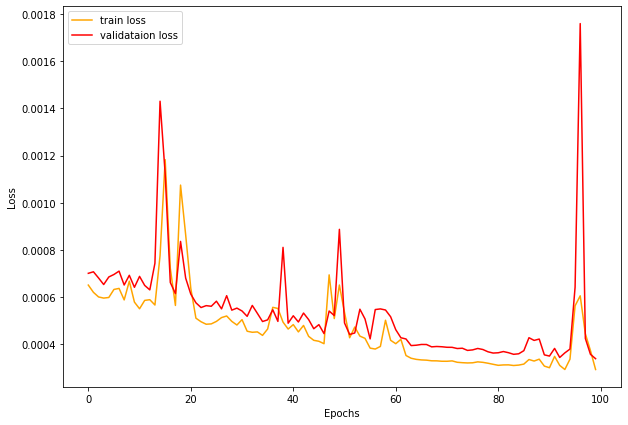

Saving model...


In [ ]:
  # loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/50Output/loss.png')
plt.show()
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), '/content/drive/MyDrive/50Output/model.pth')